## epitopepredict library basics

epitopepredict provides a standardized programmatic interface for executing several epitope/MHC binding prediction methods. The results from each method can then be processed and visualized in a consistent manner. The Tepitope module implements the TEPITOPEPan method and requires no external program to run. netMHCIIpan must be downloaded separately from the website and installed on your system. 

### References:

D. Farrell and S. V Gordon, “Epitopemap: a web application for integrated whole proteome epitope prediction,” BMC Bioinformatics, vol. 16, no. 1, p. 221, 2015.

L. Zhang, Y. Chen, H.-S. Wong, S. Zhou, H. Mamitsuka, and S. Zhu, “TEPITOPEpan: extending TEPITOPE for peptide binding prediction covering over 700 HLA-DR molecules.,” PLoS One, vol. 7, no. 2, p. e30483, Jan. 2012.

A. S. De Groot and W. Martin, “Reducing risk, improving outcomes: bioengineering less immunogenic protein therapeutics.,” Clin. Immunol., vol. 131, no. 2, pp. 189–201, May 2009.

F. a Chaves, A. H. Lee, J. L. Nayak, K. a Richards, and A. J. Sant, “The utility and limitations of current Web-available algorithms to predict peptides recognized by CD4 T cells in response to pathogen infection.,” J. Immunol., vol. 188, no. 9, pp. 4235–48, May 2012.

In [56]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.width', 120)
pd.set_option('max_colwidth', 80)
%matplotlib inline
import matplotlib as mpl
import epitopepredict as ep
from epitopepredict import sequtils, analysis, plotting, utilities

## Load sequences from fasta or genbank file

In [35]:
genbankfile = '../testing/zaire-ebolavirus.gb'
fastafile = '../testing/zaire-ebolavirus.faa'

#get data in fasta format
zaire = sequtils.fasta2Dataframe(fastafile)
#get data in genbank format into a dataframe
zaire = sequtils.genbank2Dataframe(genbankfile, cds=True)

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins should be called with save=True so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in msgpack format.

In [36]:
#get list of predictors
print ep.predictors

['tepitope', 'netmhciipan', 'iedbmhc1', 'iedbmhc2', 'mhcflurry', 'bcell']


In [47]:
savepath = 'testing'
#create tepitope predictor
P = ep.getPredictor('tepitope')

#run prediction for several alleles and save results to savepath
alleles = ep.mhc2_supertypes
P.predictProteins(zaire,length=11,alleles=alleles,path=savepath)
#note that if we provided a path data is written to disk and not kept in the object by default
#we can reload
P.load(path=savepath)
P.summarize()
P.allele_summary()
P.protein_summary()

predictions done for 9 proteins in 7 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/testing
summary: 32418 peptides in 9 proteins and 6 alleles
            peptide
name               
ZEBOVgp1       4374
ZEBOVgp2       1980
ZEBOVgp3       1896
ZEBOVgp4       3996
ZEBOVgp4.1     2124
ZEBOVgp4.2     1722
ZEBOVgp5       1668
ZEBOVgp6       1446
ZEBOVgp7      13212


## Results are kept in pandas dataframes

Here name is the protein identifier from the input file (a locus tag for example) and a score column which will differ between methods. Methods can be run for varying peptide lengths, with the core usually being the highest scoring in that peptide/n-mer (but not always). MHC-I methods may have a 'core' field for convenience but it is the same as the peptide.

In [49]:
b = P.getBinders(cutoff=5)
print 'results format:'
print b[:10]

results format:
         peptide       core  pos  score      name         allele  rank
198  VIFRLMRTNFL  FRLMRTNFL  198    3.4  ZEBOVgp1  HLA-DRB1*0101   1.0
199  IFRLMRTNFLI  FRLMRTNFL  199    3.4  ZEBOVgp1  HLA-DRB1*0101   1.0
200  FRLMRTNFLIK  FRLMRTNFL  200    3.4  ZEBOVgp1  HLA-DRB1*0101   1.0
709  NRFVTLDGQQF  FVTLDGQQF  709    2.5  ZEBOVgp1  HLA-DRB1*0101   4.0
710  RFVTLDGQQFY  FVTLDGQQF  710    2.5  ZEBOVgp1  HLA-DRB1*0101   4.0
711  FVTLDGQQFYW  FVTLDGQQF  711    2.5  ZEBOVgp1  HLA-DRB1*0101   4.0
70   DSFLLMLCLHH  FLLMLCLHH   70    2.0  ZEBOVgp1  HLA-DRB1*0101   7.0
71   SFLLMLCLHHA  FLLMLCLHH   71    2.0  ZEBOVgp1  HLA-DRB1*0101   7.0
72   FLLMLCLHHAY  FLLMLCLHH   72    2.0  ZEBOVgp1  HLA-DRB1*0101   7.0
32   QGIVRQRVIPV  IVRQRVIPV   32    1.7  ZEBOVgp1  HLA-DRB1*0101  10.0


## Filter/rank results

There are several possible ways to select lists of top epitope candidates from such binding predictions. Two such methods are the **rank and promiscuity approaches**. For promiscuity you can choose a global percentile cut-off and minimum number of alleles. Note that these two methods will produce similar but not identical results.


        peptide  pos      name  alleles  score      mean  median_rank       core
37  PVRSNSTIARG   18  ZEBOVgp3        4   4.30  3.202140          8.5  VRSNSTIAR
25  LVRVNRLGPGI  131  ZEBOVgp3        3   4.80  3.786867          4.0  LVRVNRLGP
18  KYIGLDPVAPG  290  ZEBOVgp3        2   5.40  3.500000          1.0  YIGLDPVAP
12  IWLPLGVADQK   93  ZEBOVgp3        2   4.10  3.800000          4.0  WLPLGVADQ
6   HPLRLLRIGNQ  144  ZEBOVgp3        2   4.10  3.543225          5.5  LRLLRIGNQ
47  VNVISGPKVLM   78  ZEBOVgp3        2   4.40  2.635000          7.0  VNVISGPKV
26  MRRVILPTAPP    0  ZEBOVgp3        2   3.60  3.025000         10.0  MRRVILPTA
19  LLRIGNQAFLQ  148  ZEBOVgp3        2   3.86  2.280000         11.5  LRIGNQAFL

         peptide  pos  rank      name
313  YPVRSNSTIAR   17  12.0  ZEBOVgp3
216  PVRSNSTIARG   18  12.0  ZEBOVgp3
304  VRSNSTIARGG   19  12.0  ZEBOVgp3
204  PLVRVNRLGPG  130  13.5  ZEBOVgp3
174  NPLVRVNRLGP  129  13.5  ZEBOVgp3
159  LVRVNRLGPGI  131  13.5  ZEBOVgp3
164 

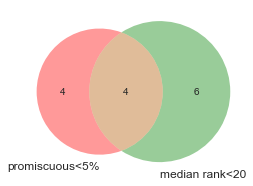

In [60]:
#get promiscuous binders in at least 2 alleles above 5 percentile cutoff
name='ZEBOVgp3'
pb = P.promiscuousBinders(name=name,n=2,cutoff=5)
print pb
print
#binders sorted by median rank over all alleles, cutoff here is the median rank
mb = P.consensusRankedBinders(name=name,cutoff=20)
print mb

ax=utilities.venndiagram([pb.peptide, mb.peptide],
                      ['promiscuous<5%','median rank<20'])

## Plotting results
Plots are primarily needed to show predicted binders over protein sequences. Since sequences are usually several hundred amino acids in length and multiple alleles are used vasrious ways of summerizing the results can be useful. Three formats are available: as a heatmap, bar plot or as tracks showing overlapping binders per allele.

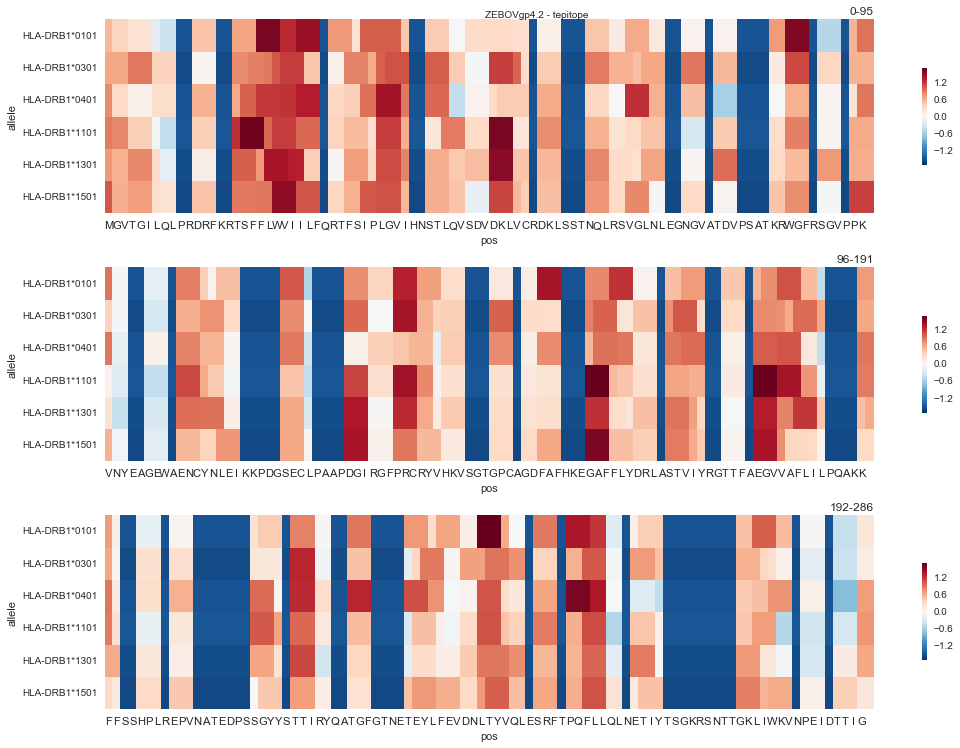

In [33]:
reload(plotting)
ax=plotting.plot_binder_map(P, name, 'score', chunks=3)

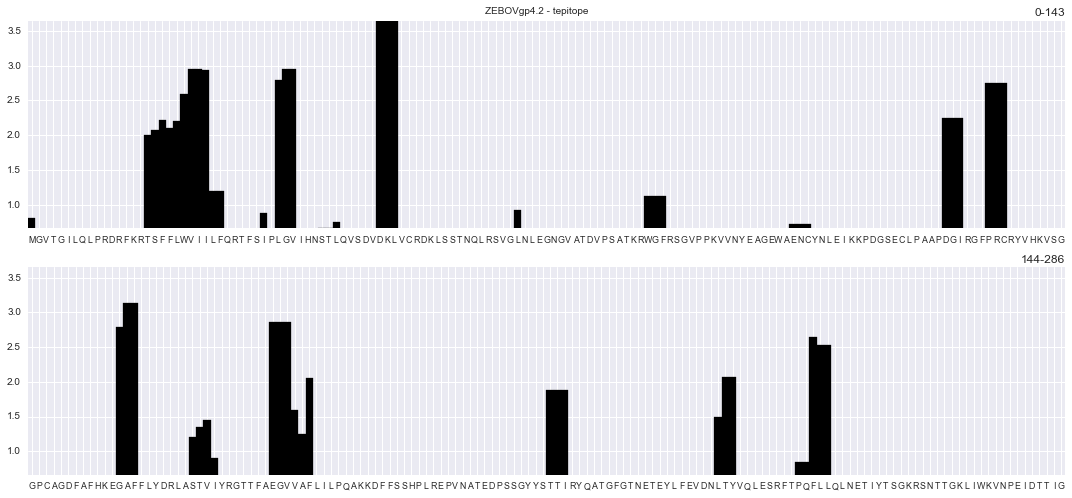

In [28]:
ax=plotting.plot_bars(P, name, cutoff=20, chunks=2) 

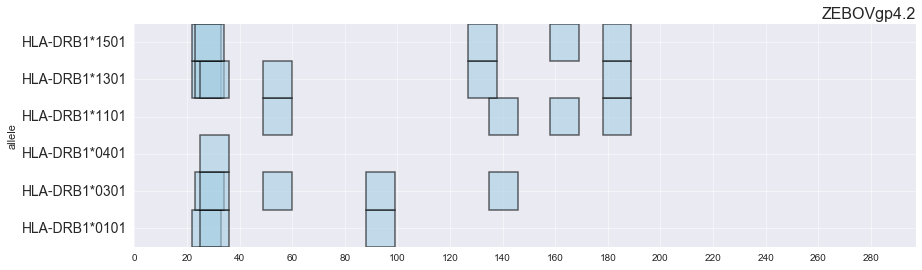

In [40]:
ax=plotting.plot_tracks([P], name, cutoff=5, n=2, figsize=(14,4))

## Epitopes: binder clustering

One application of immunoinformatics is to screen out likely candidate antigens from the genome for further study. To do this using epitope prediction requires filtering the many potential binders in each protein. There is no theoretical basis for doing this.

Epitope clustering has been previously observed to be an indicator of T cell epitope regions. The `findClusters` method in the analysis module allows automatic cluster detection from a set of predicted binders from one or more proteins. It can be done for a whole genome.

The result is a table of sequence regions with the number of binders and density of epitope cluster.

In [43]:
#find clusters of binders in these results
b = P.getBinders(cutoff=5)
cl = analysis.findClusters(b, dist=10, min_size=2, genome=zaire)
print cl

125 clusters found in 8 proteins
         name  start   end  binders  clustersize  gene                                            peptide
0    ZEBOVgp1    188   229       60           41    NP          TAWQSVGHMMVIFRLMRTNFLIKFLLIHQGMHMVAGHDAND
1    ZEBOVgp6     18    67       32           49  VP24  KGVVLSDLCNFLVSQTIQGWKVYWAGIEFDVTHKGMALLHRLKTNDFAP
2    ZEBOVgp7   1453  1485       31           32     L                   THFLTYPKIGLLYSFGAFVSYYLGNTILRTKK
3    ZEBOVgp7   2111  2147       31           36     L               QTYHFIRTAKGRITKLVNDYLKFFLIVQALKHNGTW
4    ZEBOVgp4     16    47       29           31    GP                    TSFFLWVIILFQRTFSIPLGVIHNSTLQVSD
5    ZEBOVgp5    232   267       28           35  VP30                QSLIMFITAFLNIALQLPCESSAVVVSGLRTLVPQ
6    ZEBOVgp7    981   998       28           17     L                                  SFLRQIVRRTITLSAKN
7    ZEBOVgp7    233   256       27           23     L                            ADVLIMCKDLITCRFNTTLISKI
8    ZEBOVgp5